# Object detection

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip -qq /content/drive/MyDrive/object_detection_dataset.zip

object_detection_dataset/rabbit/Lepus_europaeus_(Causse_Méjean,_Lozère)-cropped.jpg:  mismatching "local" filename (object_detection_dataset/rabbit/Lepus_europaeus_(Causse_M├йjean,_Loz├иre)-cropped.jpg),
         continuing with "central" filename version


In [4]:
import cv2
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from sklearn import metrics
from sklearn.metrics import classification_report
import torch
from PIL import Image
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, confusion_matrix
import torchvision
import torchvision.transforms as transforms
import seaborn as sns
from tqdm import tqdm
from pathlib import Path
import imutils
from imutils.object_detection import non_max_suppression

In [5]:
def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(12345)

In [6]:
dataset_path = '/content/object_detection_dataset'

def get_image_paths(base_path, subfolder, extensions):
    base_dir = Path(base_path) / subfolder
    return [str(path) for ext in extensions for path in base_dir.rglob(f"*.{ext}")]

extensions = ['jpg', 'png', 'jpeg', 'jfif']

image_paths_bear = get_image_paths(dataset_path, 'bear', extensions)
image_paths_fox = get_image_paths(dataset_path, 'fox', extensions)
image_paths_rabbit = get_image_paths(dataset_path, 'rabbit', extensions)
image_paths_wolf = get_image_paths(dataset_path, 'wolf', extensions)

In [7]:
len(image_paths_bear), len(image_paths_fox), len(image_paths_rabbit), len(image_paths_wolf)

(50, 51, 52, 53)

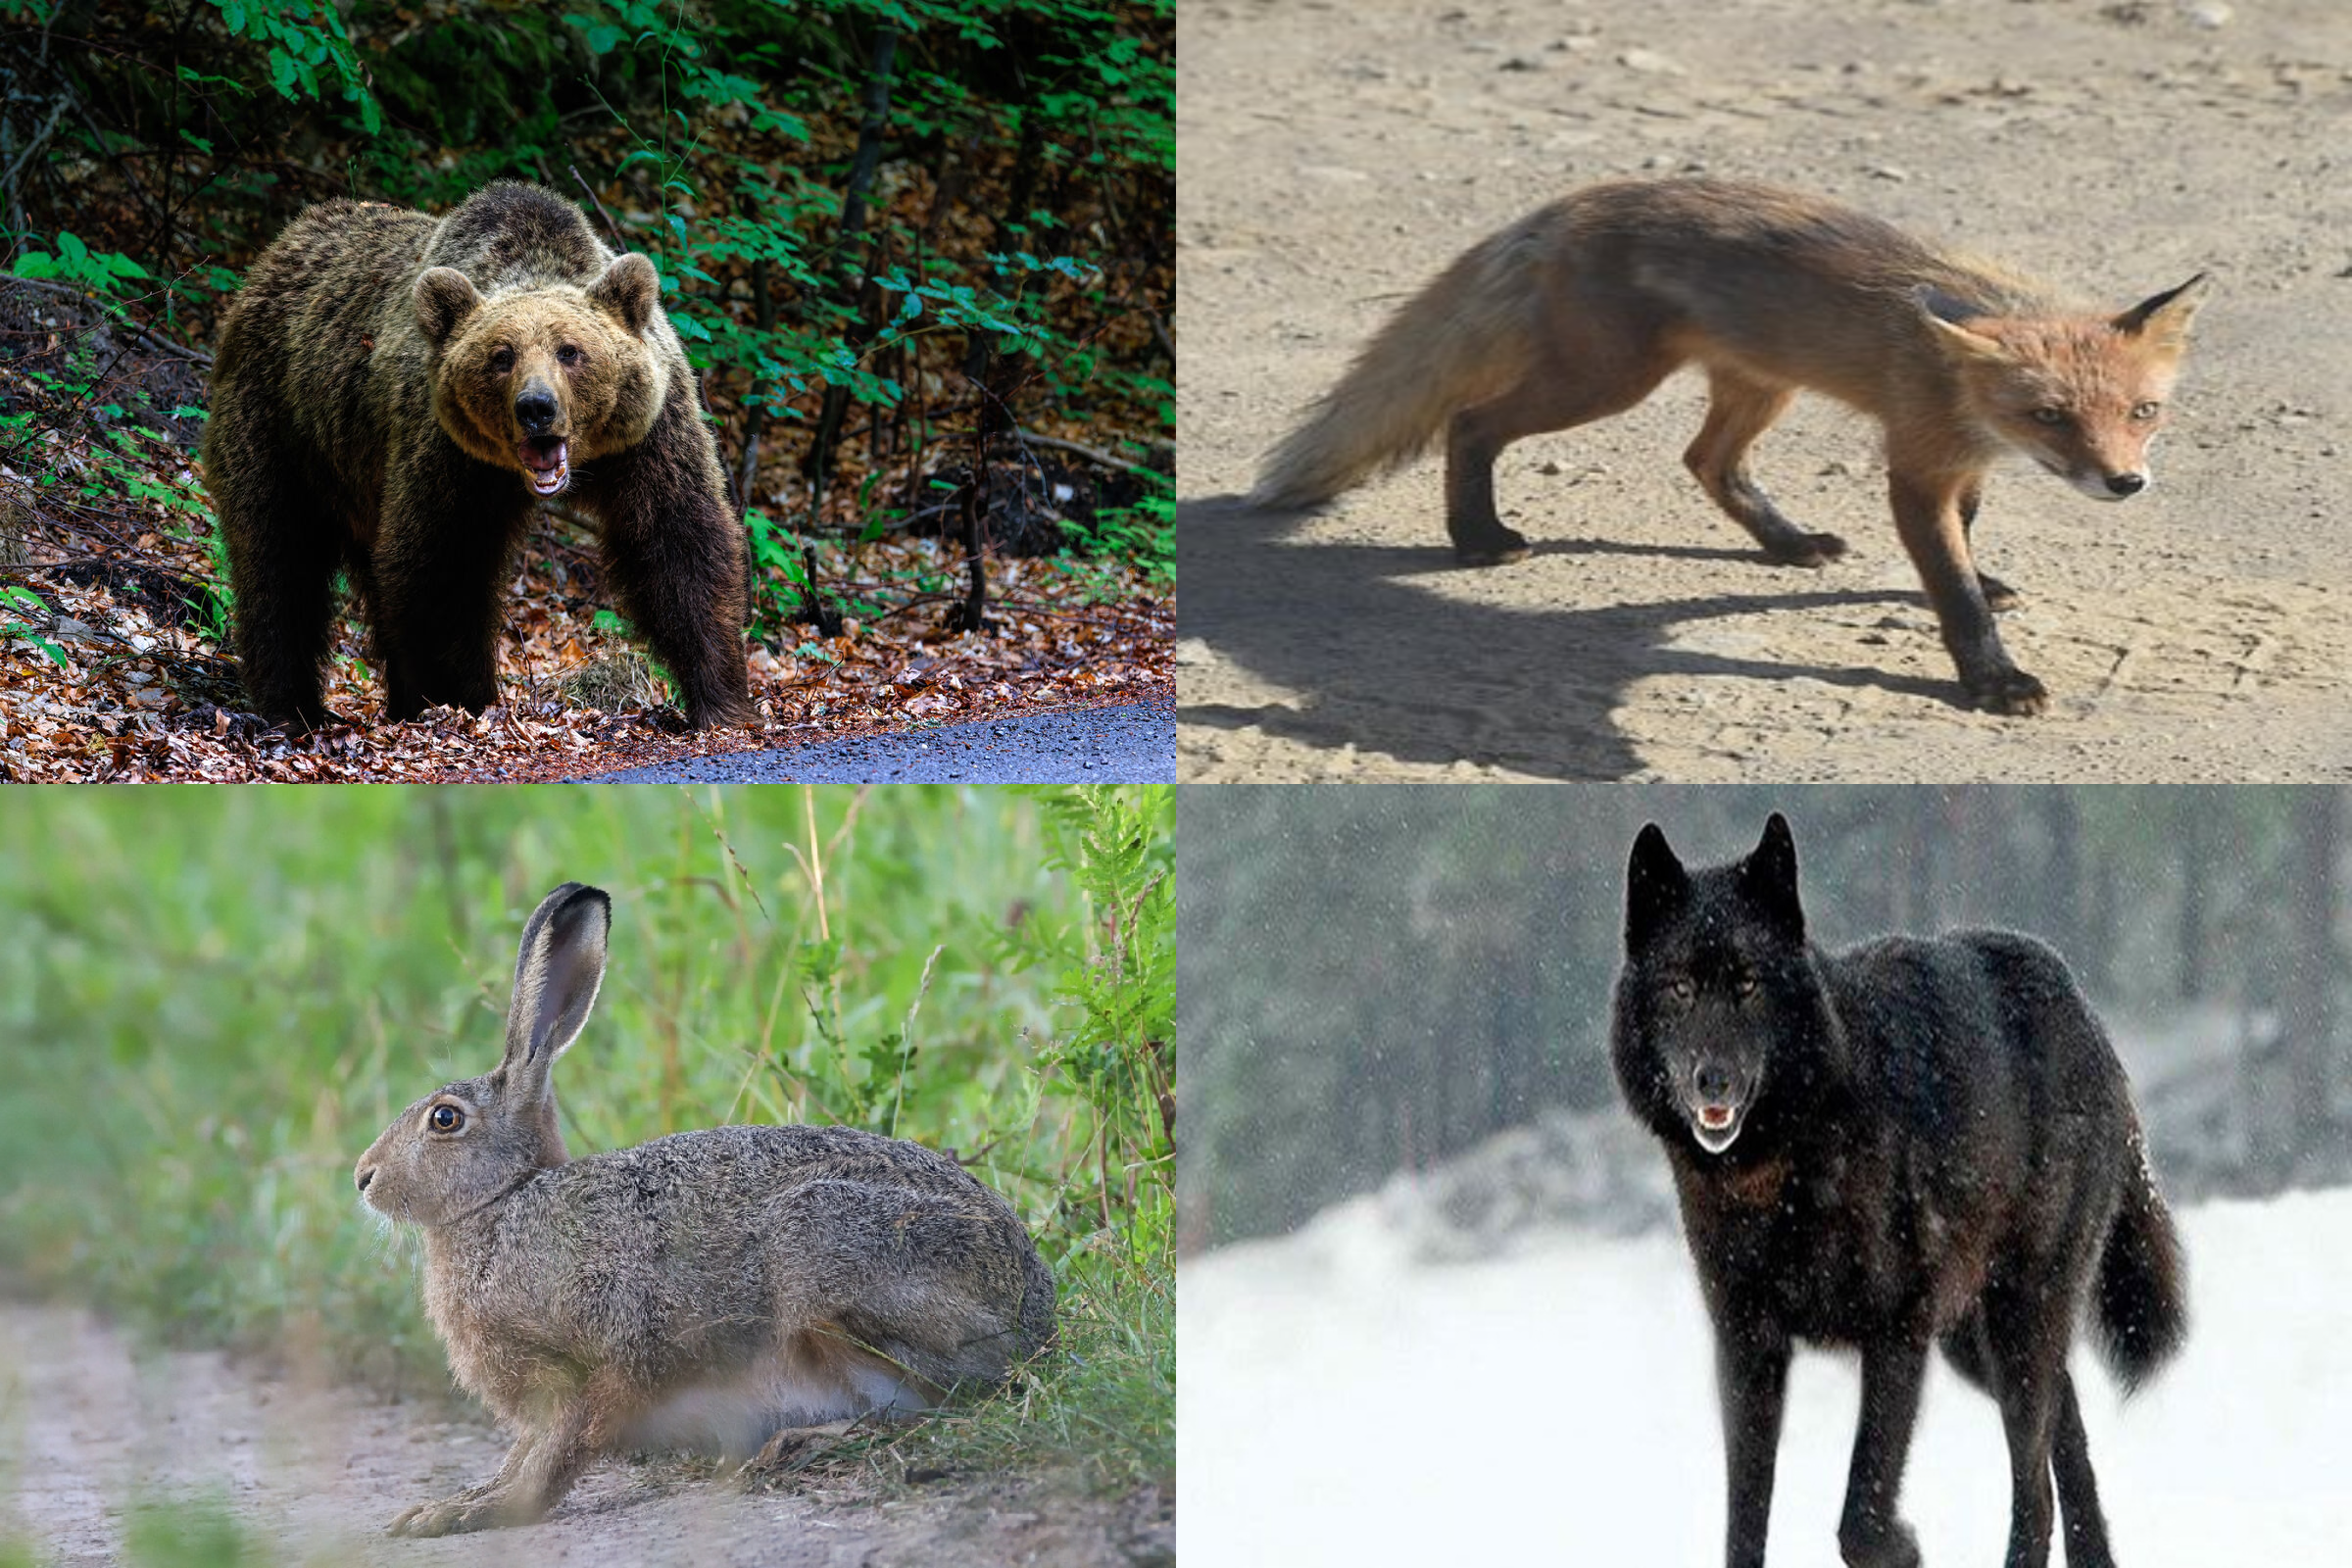

In [ ]:
img_bear = cv2.imread(image_paths_bear[0])[:, :, ::-1]
img_fox = cv2.imread(image_paths_fox[0])[:, :, ::-1]
img_rabbit = cv2.imread(image_paths_rabbit[0])[:, :, ::-1]
img_wolf = cv2.imread(image_paths_wolf[0])[:, :, ::-1]

max_height = max(img_bear.shape[0], img_fox.shape[0], img_rabbit.shape[0], img_wolf.shape[0])
max_width = max(img_bear.shape[1], img_fox.shape[1], img_rabbit.shape[1], img_wolf.shape[1])

def resize_to_max(img, width, height):
    return cv2.resize(img, (width, height))

img_bear_resized = resize_to_max(img_bear, max_width, max_height)
img_fox_resized = resize_to_max(img_fox, max_width, max_height)
img_rabbit_resized = resize_to_max(img_rabbit, max_width, max_height)
img_wolf_resized = resize_to_max(img_wolf, max_width, max_height)

top_row = np.concatenate([img_bear_resized, img_fox_resized], axis=1)
bottom_row = np.concatenate([img_rabbit_resized, img_wolf_resized], axis=1)
grid = np.concatenate([top_row, bottom_row], axis=0)

Image.fromarray(grid)

## Метод сканирующего окна с HOG-дескриптором

In [105]:
batch_size = 24
n_epochs = 40
device = 'cuda:0'

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

class FeatureExtractor:
    def __init__(self, transform=None):
        self.transform = transform

        self.hog = cv2.HOGDescriptor()

    def get_feature(self, image_path):
        image = cv2.imread(image_path)
        pil_image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

        transformed_image = self.transform(pil_image)

        gray_image = np.array(transformed_image.permute(1, 2, 0).cpu(), dtype=np.uint8)
        gray_image = cv2.cvtColor(gray_image, cv2.COLOR_RGB2GRAY)

        features = self.hog.compute(gray_image, winStride=(8, 8), padding=(0, 0))

        return features.flatten()

fe = FeatureExtractor(transform=transform)

In [9]:
dataset = (
    [(fe.get_feature(image_path), 0) for image_path in image_paths_bear] +
    [(fe.get_feature(image_path), 1) for image_path in image_paths_fox] +
    [(fe.get_feature(image_path), 2) for image_path in image_paths_rabbit] +
    [(fe.get_feature(image_path), 3) for image_path in image_paths_wolf]
)

random.shuffle(dataset)

dataset_train = dataset[:int(0.8*len(dataset))]
dataset_train_features = [el[0] for el in dataset_train]
dataset_train_labels = [el[1] for el in dataset_train]

dataset_test  = dataset[int(0.8*len(dataset)):]
dataset_test_features = [el[0] for el in dataset_test]
dataset_test_labels = [el[1] for el in dataset_test]

print(len(dataset_train), len(dataset_test))

164 42


In [10]:
dataset = torchvision.datasets.ImageFolder(root='/content/object_detection_dataset', transform=transform)
valid_size = int(len(dataset) * 0.1)
train_set, valid_set = torch.utils.data.random_split(dataset, [len(dataset) - valid_size, valid_size])
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
valid_dataloader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=2)

Для классификации используем модель resnet50

In [16]:
def train_and_evaluate_model(model):
    for param in model.parameters():
        param.requires_grad = False

    model.fc = torch.nn.Linear(model.fc.in_features, 4)

    for param in model.fc.parameters():
        param.requires_grad = True

    model.to(device)

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)

    for epoch in range(1, n_epochs + 1):
        model.train()
        train_loss = []
        for data, target in tqdm(train_dataloader, desc=f'Epoch {epoch}'):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            train_loss.append(loss.item())
            optimizer.step()

        val_loss = []
        model.eval()
        with torch.no_grad():
            for data, target in valid_dataloader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                val_loss.append(loss.item())

        print(f'Epoch {epoch}, train loss: {np.mean(train_loss):.4f}, valid loss: {np.mean(val_loss):.4f}.')

    pred_list = []
    y_list = []
    with torch.no_grad():
        for data, target in valid_dataloader:
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            preds = torch.softmax(output, dim=1)
            pred_list.extend(preds.cpu().numpy())
            y_list.extend(target.cpu().numpy())

    pred_classes = np.argmax(pred_list, axis=1)
    print(classification_report(y_list, pred_classes, target_names=['Bear', 'Fox', 'Rabbit', 'Wolf']))

    cm = confusion_matrix(y_list, pred_classes)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Bear', 'Fox', 'Rabbit', 'Wolf'], yticklabels=['Bear', 'Fox', 'Rabbit', 'Wolf'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1: 100%|██████████| 7/7 [00:02<00:00,  3.22it/s]


Epoch 1, train loss: 0.9074, valid loss: 0.1245.


Epoch 2: 100%|██████████| 7/7 [00:01<00:00,  4.04it/s]


Epoch 2, train loss: 0.3359, valid loss: 0.0742.


Epoch 3: 100%|██████████| 7/7 [00:01<00:00,  3.60it/s]


Epoch 3, train loss: 0.0867, valid loss: 0.1468.


Epoch 4: 100%|██████████| 7/7 [00:02<00:00,  2.39it/s]


Epoch 4, train loss: 0.0631, valid loss: 0.0907.


Epoch 5: 100%|██████████| 7/7 [00:01<00:00,  3.90it/s]


Epoch 5, train loss: 0.0394, valid loss: 0.0351.


Epoch 6: 100%|██████████| 7/7 [00:01<00:00,  3.93it/s]


Epoch 6, train loss: 0.0203, valid loss: 0.0355.


Epoch 7: 100%|██████████| 7/7 [00:01<00:00,  3.87it/s]


Epoch 7, train loss: 0.0118, valid loss: 0.0658.


Epoch 8: 100%|██████████| 7/7 [00:01<00:00,  3.84it/s]


Epoch 8, train loss: 0.0098, valid loss: 0.1026.


Epoch 9: 100%|██████████| 7/7 [00:03<00:00,  2.32it/s]


Epoch 9, train loss: 0.0220, valid loss: 0.1489.


Epoch 10: 100%|██████████| 7/7 [00:01<00:00,  3.94it/s]


Epoch 10, train loss: 0.0299, valid loss: 0.0894.


Epoch 11: 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]


Epoch 11, train loss: 0.0183, valid loss: 0.0518.


Epoch 12: 100%|██████████| 7/7 [00:01<00:00,  3.96it/s]


Epoch 12, train loss: 0.0150, valid loss: 0.1001.


Epoch 13: 100%|██████████| 7/7 [00:01<00:00,  3.90it/s]


Epoch 13, train loss: 0.0432, valid loss: 0.0655.


Epoch 14: 100%|██████████| 7/7 [00:02<00:00,  2.35it/s]


Epoch 14, train loss: 0.0187, valid loss: 0.3779.


Epoch 15: 100%|██████████| 7/7 [00:01<00:00,  3.61it/s]


Epoch 15, train loss: 0.0844, valid loss: 0.0778.


Epoch 16: 100%|██████████| 7/7 [00:01<00:00,  4.03it/s]


Epoch 16, train loss: 0.0550, valid loss: 0.1255.


Epoch 17: 100%|██████████| 7/7 [00:01<00:00,  3.92it/s]


Epoch 17, train loss: 0.0143, valid loss: 0.1308.


Epoch 18: 100%|██████████| 7/7 [00:03<00:00,  1.96it/s]


Epoch 18, train loss: 0.0272, valid loss: 0.1660.


Epoch 19: 100%|██████████| 7/7 [00:02<00:00,  2.42it/s]


Epoch 19, train loss: 0.0234, valid loss: 0.1117.


Epoch 20: 100%|██████████| 7/7 [00:01<00:00,  3.92it/s]


Epoch 20, train loss: 0.0052, valid loss: 0.0844.


Epoch 21: 100%|██████████| 7/7 [00:01<00:00,  3.80it/s]


Epoch 21, train loss: 0.0124, valid loss: 0.0751.


Epoch 22: 100%|██████████| 7/7 [00:01<00:00,  3.97it/s]


Epoch 22, train loss: 0.0171, valid loss: 0.0726.


Epoch 23: 100%|██████████| 7/7 [00:01<00:00,  3.91it/s]


Epoch 23, train loss: 0.0169, valid loss: 0.0765.


Epoch 24: 100%|██████████| 7/7 [00:02<00:00,  2.34it/s]


Epoch 24, train loss: 0.0477, valid loss: 0.1654.


Epoch 25: 100%|██████████| 7/7 [00:01<00:00,  3.62it/s]


Epoch 25, train loss: 0.0158, valid loss: 0.1594.


Epoch 26: 100%|██████████| 7/7 [00:02<00:00,  2.42it/s]


Epoch 26, train loss: 0.0100, valid loss: 0.0969.


Epoch 27: 100%|██████████| 7/7 [00:01<00:00,  3.88it/s]


Epoch 27, train loss: 0.0138, valid loss: 0.0759.


Epoch 28: 100%|██████████| 7/7 [00:02<00:00,  2.69it/s]


Epoch 28, train loss: 0.0240, valid loss: 0.0488.


Epoch 29: 100%|██████████| 7/7 [00:03<00:00,  2.26it/s]


Epoch 29, train loss: 0.0154, valid loss: 0.1338.


Epoch 30: 100%|██████████| 7/7 [00:01<00:00,  3.98it/s]


Epoch 30, train loss: 0.0105, valid loss: 0.2255.


Epoch 31: 100%|██████████| 7/7 [00:01<00:00,  3.90it/s]


Epoch 31, train loss: 0.1112, valid loss: 0.1514.


Epoch 32: 100%|██████████| 7/7 [00:01<00:00,  3.96it/s]


Epoch 32, train loss: 0.0211, valid loss: 0.0843.


Epoch 33: 100%|██████████| 7/7 [00:01<00:00,  3.90it/s]


Epoch 33, train loss: 0.0628, valid loss: 0.0958.


Epoch 34: 100%|██████████| 7/7 [00:02<00:00,  2.43it/s]


Epoch 34, train loss: 0.0082, valid loss: 0.1891.


Epoch 35: 100%|██████████| 7/7 [00:01<00:00,  3.74it/s]


Epoch 35, train loss: 0.0201, valid loss: 0.1755.


Epoch 36: 100%|██████████| 7/7 [00:01<00:00,  3.96it/s]


Epoch 36, train loss: 0.0041, valid loss: 0.1239.


Epoch 37: 100%|██████████| 7/7 [00:01<00:00,  3.91it/s]


Epoch 37, train loss: 0.0338, valid loss: 0.0842.


Epoch 38: 100%|██████████| 7/7 [00:01<00:00,  3.97it/s]


Epoch 38, train loss: 0.0091, valid loss: 0.0699.


Epoch 39: 100%|██████████| 7/7 [00:02<00:00,  2.38it/s]


Epoch 39, train loss: 0.0050, valid loss: 0.0648.


Epoch 40: 100%|██████████| 7/7 [00:02<00:00,  3.34it/s]


Epoch 40, train loss: 0.0180, valid loss: 0.0605.
              precision    recall  f1-score   support

        Bear       1.00      1.00      1.00         7
         Fox       1.00      1.00      1.00         2
      Rabbit       1.00      1.00      1.00         2
        Wolf       1.00      1.00      1.00         6

    accuracy                           1.00        17
   macro avg       1.00      1.00      1.00        17
weighted avg       1.00      1.00      1.00        17



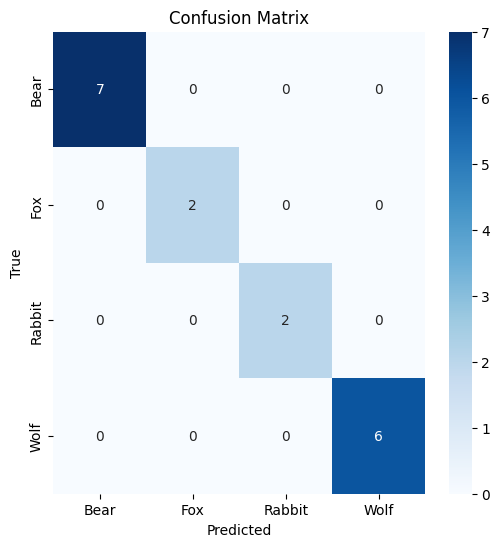

In [17]:
model = torchvision.models.resnet50(pretrained=True)
train_and_evaluate_model(model)

In [18]:
def sliding_window(image, step, ws):
    #slide a window of ws size over the image
    for y in range(0, image.shape[0]-ws[1], step): # rows-wise loop
        # -ws[1] avoids extending the sliding window outside the image itself, increment the y-position with step
        for x in range(0, image.shape[1] - ws[0], step):#columns-wise loop, increment the x-position with step
            # use yield(instead of return) because this is a generator
            #yield the actual x and y positions and the current window
            yield (x, y, image[y:y + ws[1], x:x + ws[0]])


def image_pyramid(image, scale=1.5, minSize=(224, 224)):
    # yield the original image, this is the base of the image pyramid
    yield image
    # keep looping over the image pyramid
    while True:
        # compute the dimensions of the next image in the pyramid
        #scale controls how much the image is resized at each layer
        w = int(image.shape[1] / scale)
        # resize the image and take care of image aspect-ratio
        image = imutils.resize(image, width=w)
        # if the resized image does not meet the supplied minimum
        # size, then stop constructing the pyramid
        if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
            break
        # yield the next image in the pyramid
        yield image

In [19]:
WIDTH = 600
PYR_SCALE = 1.5
WIN_STEP = 16*3 # running on laptop so I generated a small pyramid
ROI_SIZE = (200, 150)
INPUT_SIZE = (224, 224)

In [21]:
test_image_path = 'test_image.jpg'

image = cv2.imread(test_image_path)[..., ::-1]
image = cv2.resize(image, (400, 300))
orig = image.copy()
h, w = image.shape[:2]

In [22]:
model.eval()

# initialize the image pyramid
pyramid = image_pyramid(orig, scale=PYR_SCALE, minSize=ROI_SIZE)
# initialize two lists, one to hold the ROIs generated from the image pyramid
#and sliding window, and another list used to store the
# (x, y)-coordinates of where the ROI was in the original image
rois = []
locs = []
counter = 0
tot_images = 0
for p, image in tqdm(enumerate(pyramid)):
    # determine the scale factor between the *original* image
    # dimensions and the *current* layer of the pyramid
    scale = w / float(image.shape[1])
    # for each layer of the image pyramid, loop over the sliding
    # window locations
    sw = 0
    for (x, y, roiOrig) in sliding_window(image, WIN_STEP, ROI_SIZE):
        sw = sw + 1
        # scale the (x, y)-coordinates of the ROI with respect to the
        # *original* image dimensions
        x = int(x * scale)
        y = int(y * scale)
        w = int(ROI_SIZE[0] * scale)
        h = int(ROI_SIZE[1] * scale)
        # take the ROI and pre-process it so we can later classify
        # the region using Keras/TensorFlow
        roi = cv2.resize(roiOrig, INPUT_SIZE)

        roi = fe.transform(Image.fromarray(roi))
        rois.append(roi.unsqueeze(0))
        locs.append((x, y, x + w, y + h))
        # check to see if we are visualizing each of the sliding
        # windows in the image pyramid
        tot_images = tot_images +1

print(roiOrig.shape, roi.shape)
print("Total images {:.2f}".format(tot_images))

2it [00:00, 63.81it/s]

(150, 200, 3) torch.Size([3, 128, 128])
Total images 24.00


In [23]:
rois = torch.cat(rois)

with torch.no_grad():
  my_preds = model(rois.to(device)).squeeze()

my_preds = torch.nn.functional.softmax(my_preds)
idxs = torch.argmax(my_preds, axis=1)

<ipython-input-23-48d04838fc68>:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  my_preds = torch.nn.functional.softmax(my_preds)


In [28]:
class_names = {
    0: 'bear',
    1: 'fox',
    2: 'rabbit',
    3: 'wolf'
}

labels = {}
for i, idx in enumerate(idxs):
    idx = idx.item()
    label = class_names[idx]
    prob = my_preds[i][idx].item()
    if prob >= 0.7:
        box = locs[i]

        L = labels.get(label, [])
        L.append((box, prob))
        labels[label] = L

[INFO] showing results for 'rabbit'
[INFO] showing results for 'bear'


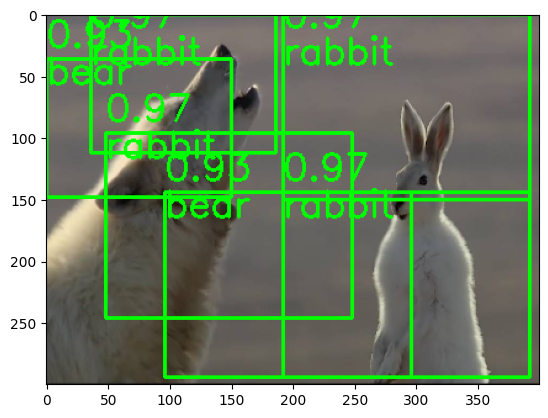

In [25]:
allclone = orig.copy()
for label in labels.keys():
    # clone the original image so that we can draw on it
    print("[INFO] showing results for '{}'".format(label))
    clone = orig.copy()

    # loop over all bounding boxes for the current label
    for (box, prob) in labels[label]:
        # draw the bounding box on the image
        (startX, startY, endX, endY) = box
        cv2.rectangle(clone, (startX, startY), (endX, endY),(0, 255, 0), 2)

    # show the results *before* applying non-maxima suppression, then
    # clone the image again so we can display the results *after*
    # applying non-maxima suppression
    #plt.imshow(clone)
    #cv2.imshow("Before", clone)
    clone = orig.copy()

    # extract the bounding boxes and associated prediction
    # probabilities, then apply non-maxima suppression
    boxes = np.array([p[0] for p in labels[label]])
    proba = np.array([p[1] for p in labels[label]])
    boxes = non_max_suppression(boxes, proba)

    # loop over all bounding boxes that were kept after applying
    # non-maxima suppression
    for (startX, startY, endX, endY) in boxes:
        # draw the bounding box and label on the image
        cv2.rectangle(clone, (startX, startY), (endX, endY),(0, 255, 0), 2)
        cv2.rectangle(allclone, (startX, startY), (endX, endY),(0, 255, 0), 2)
        y = startY - 10 if startY - 10 > 10 else startY + 10
        cv2.putText(clone, label, (startX, y+30),cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        cv2.putText(clone, "{:.2f}".format(prob), (startX, y),cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        cv2.putText(allclone, label, (startX, y+30),cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        cv2.putText(allclone, "{:.2f}".format(prob), (startX, y),cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    # show the output after apply non-maxima suppression
    plt.imshow(clone)
plt.imshow(allclone)

## Тюнинг Yolo

In [ ]:
!unzip -qq /content/forest_animals.v1i.yolov5pytorch.zip

In [ ]:
!git clone https://github.com/ultralytics/yolov5
%cd /content/yolov5
!pip install -r requirements.txt
!mv /content/data.yaml /content/yolov5

Для тюнинга Yolo разметим предыдущий датасет в Robowlow и загрузим в формате Yolov5. В валидационную выборку добавим новые изображения, которые не были добавлены при обучении resnet50.

In [35]:
!cd /content/yolov5

In [37]:
!python train.py --img 640 --batch 16 --epochs 40 --data data.yaml --weights yolov5s.pt --project forest_animals --name exp1

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2024-12-14 10:58:21.682805: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-14 10:58:21.703481: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-14 10:58:21.709509: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to regi

In [43]:
!python detect.py --weights forest_animals/exp1/weights/best.pt --img 640 --conf 0.5 --source ../test_image.jpg

detect: weights=['forest_animals/exp1/weights/best.pt'], source=../test_image.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-389-ge62a31b6 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7020913 parameters, 0 gradients, 15.8 GFLOPs
WARNING ⚠️ NMS time limit 0.550s exceeded
image 1/1 /content/test_image.jpg: 448x640 1 rabbit, 35.2ms
Speed: 0.6ms pre-process, 35.2ms inference, 597.2ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp2


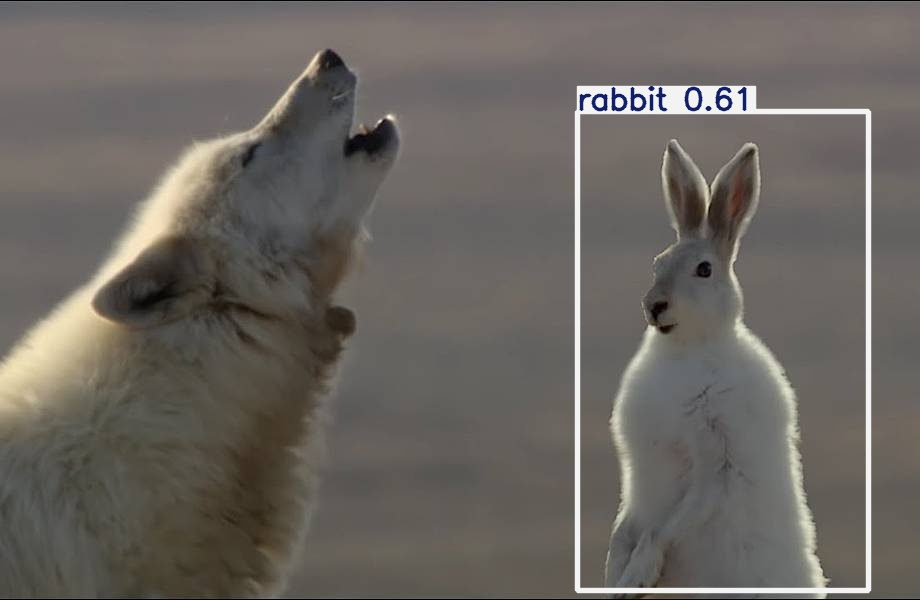

In [46]:
Image(filename='/content/yolov5/runs/detect/exp2/test_image.jpg')

## Сравнение

Для сравнения обоих моделей используем метрику mAP.

In [64]:
!python yolov5/val.py --weights yolov5/forest_animals/exp1/weights/best.pt --data data.yaml --img 640 --conf 0.5 --task val

val: data=data.yaml, weights=['yolov5/forest_animals/exp1/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.5, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=yolov5/runs/val, name=exp, exist_ok=False, half=False, dnn=False
WARNING ⚠️ confidence threshold 0.5 > 0.001 produces invalid results
YOLOv5 🚀 v7.0-389-ge62a31b6 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7020913 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning /content/yolov5/valid/labels... 35 images, 0 backgrounds, 0 corrupt: 100% 35/35 [00:00<00:00, 1101.07it/s]
val: New cache created: /content/yolov5/valid/labels.cache
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 2/2 [00:01<00:00,  1.06it/s]
                   all         35         35       0.45       0.25      0.339   

mAP50 для Yolo получилось низкое, что скорее всего связано с маленьким набором данных (120 изображений в тренировочной выборке и 16 в тестовой). Попробуем посчитать ту же метрику для 35 изображений из валидационной выборки для сканирующего окна с hog.

In [81]:
import os
import numpy as np

def load_yolo_annotations(label_path, image_size):
    h, w = image_size
    annotations = []
    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            class_id = int(parts[0])
            x_center, y_center, box_w, box_h = map(float, parts[1:])
            x_min = (x_center - box_w / 2) * w
            y_min = (y_center - box_h / 2) * h
            x_max = (x_center + box_w / 2) * w
            y_max = (y_center + box_h / 2) * h
            annotations.append((class_id, x_min, y_min, x_max, y_max))
    return annotations

In [83]:
def compute_iou(box1, box2):
    xA = max(box1[0], box2[0])
    yA = max(box1[1], box2[1])
    xB = min(box1[2], box2[2])
    yB = min(box1[3], box2[3])

    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    box1Area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    box2Area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)

    iou = interArea / float(box1Area + box2Area - interArea)
    return iou

In [96]:
def match_predictions_to_ground_truth(pred_boxes, gt_boxes, iou_threshold=0.5):
    matched_gt = set()
    tp = 0
    fp = 0
    fn = len(gt_boxes)

    for pred in pred_boxes:
        pred_class, pred_box, pred_prob = pred[0], pred[1:5], pred[5]
        matched = False
        for i, gt in enumerate(gt_boxes):
            gt_class, gt_box = gt[0], gt[1:]
            if i in matched_gt:
                continue
            if pred_class == gt_class and compute_iou(pred_box, gt_box) >= iou_threshold:
                matched_gt.add(i)
                matched = True
                tp += 1
                fn -= 1
                break
        if not matched:
            fp += 1

    return tp, fp, fn

In [97]:
def calculate_precision_recall(pred_boxes, gt_boxes, thresholds=np.arange(0, 1.05, 0.05)):
    precision = []
    recall = []

    for threshold in thresholds:
        filtered_preds = [pred for pred in pred_boxes if pred[5] >= threshold]
        tp, fp, fn = match_predictions_to_ground_truth(filtered_preds, gt_boxes)
        p = tp / (tp + fp) if (tp + fp) > 0 else 0
        r = tp / (tp + fn) if (tp + fn) > 0 else 0
        precision.append(p)
        recall.append(r)

    return precision, recall

In [98]:
def calculate_average_precision(precision, recall):
    precision = np.array(precision)
    recall = np.array(recall)

    recall = np.concatenate(([0], recall, [1]))
    precision = np.concatenate(([0], precision, [0]))

    for i in range(len(precision) - 1, 0, -1):
        precision[i - 1] = max(precision[i - 1], precision[i])

    ap = 0
    for i in range(1, len(recall)):
        ap += (recall[i] - recall[i - 1]) * precision[i]

    return ap

In [99]:
def calculate_map(all_pred_boxes, all_gt_boxes, class_count):
    aps = []
    for class_id in range(class_count):
        class_pred_boxes = [pred for pred in all_pred_boxes if pred[0] == class_id]
        class_gt_boxes = [gt for gt in all_gt_boxes if gt[0] == class_id]
        precision, recall = calculate_precision_recall(class_pred_boxes, class_gt_boxes)
        ap = calculate_average_precision(precision, recall)
        aps.append(ap)
    return np.mean(aps)

In [109]:
image_size = (300, 400)
test_images_dir = "/content/yolov5/valid/images"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
all_gt_boxes = []
for label_file in os.listdir("/content/yolov5/valid/labels"):
    label_path = os.path.join("/content/yolov5/valid/labels", label_file)
    gt_boxes = load_yolo_annotations(label_path, image_size)
    all_gt_boxes.append(gt_boxes)

all_pred_boxes = []
test_images = os.listdir(test_images_dir)

for image_name in tqdm(test_images):
    image_path = os.path.join(test_images_dir, image_name)
    image = cv2.imread(image_path)[..., ::-1]
    image = cv2.resize(image, (400, 300))
    orig = image.copy()
    h, w = image.shape[:2]

    image_pred_boxes = []
    rois = []
    locs = []

    pyramid = image_pyramid(orig, scale=PYR_SCALE, minSize=ROI_SIZE)
    for p, image in enumerate(pyramid):
        scale = w / float(image.shape[1])
        for (x, y, roiOrig) in sliding_window(image, WIN_STEP, ROI_SIZE):
            roi = cv2.resize(roiOrig, INPUT_SIZE)
            roi = fe.transform(Image.fromarray(roi)).unsqueeze(0).to(DEVICE)

            rois.append(roi)
            locs.append((int(x * scale), int(y * scale),
                         int((x + ROI_SIZE[0]) * scale), int((y + ROI_SIZE[1]) * scale)))

    if rois:
        rois = torch.cat(rois, dim=0)
        with torch.no_grad():
            preds = model(rois).squeeze()
        preds = torch.nn.functional.softmax(preds, dim=1)
        idxs = torch.argmax(preds, dim=1)

        for i, idx in enumerate(idxs):
            class_id = idx.item()
            prob = preds[i][idx].item()
            if prob >= 0.7:
                box = locs[i]
                image_pred_boxes.append((class_id, *box, prob))

    all_pred_boxes.append(image_pred_boxes)

class_count = len(class_names)
mAP = calculate_map(all_pred_boxes, all_gt_boxes, class_count)
print(f"mAP: {mAP:.4f}")

100%|██████████| 35/35 [00:02<00:00, 11.72it/s]

mAP: 0.0000


In [110]:
print(f"mAP: {mAP:.4f}")

mAP: 0.0000


Метрика mAP для подхода со скользящим окном оказалась очень близкой к нулю, что ожидаемо, учитывая маленький набор данных. Поскольку для модели YOLO удалось достичь mAP, равного 0.33, для метода скользящего окна ожидалось еще более низкое значение (так как он сильно уступает по сложности YOLO), что и было подтверждено этим результатом. Помимо увеличения набора данных, улучшение метрики возможно за счет изменения размеров окна, используемого в алгоритме.